In [1]:
import pickle
import numpy as np 
import pandas as pd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib as mpl
import os 
import glob

mpl.rcParams['figure.figsize'] = (5,5)
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams["image.origin"] = 'lower'

In [2]:
model_name = "v6_elegammasep"
model_dir = "../models/"+model_name
model_tag = "300x3"
det = "EE"
flavour = "gamma"
model_version = 1
numpy_version = 1
limit_files = 100
cols = ["seed_eta", "seed_iz","en_seed","et_seed",
        "cluster_deta", "cluster_dphi", "en_cluster", "et_cluster",
       "seed_f5_r9", "seed_f5_sigmaIetaIeta","seed_f5_sigmaIetaIphi","seed_f5_sigmaIphiIphi",
        "seed_f5_swissCross","seed_nxtals", "seed_etaWidth", "seed_phiWidth",
        "cl_f5_r9", "cl_f5_sigmaIetaIeta","cl_f5_sigmaIetaIphi","cl_f5_sigmaIphiIphi",
        "cl_f5_swissCross", "cl_nxtals", "cl_etaWidth", "cl_phiWidth"]

os.makedirs(model_dir, exist_ok = True)
with open("variables.txt", "w") as of:
    of.write("\n".join(cols))

# Data preparation
## Input: 
- E seed
- eta,phi,z seed
- E cluster
- delta_eta,delta_phi,

Filter only windows with the calo

In [3]:
files_ele = f"/storage/ECAL/training_data/wp_comparison/electrons/numpy_wp_ele_v{numpy_version}/training/"
files_gamma = f"/storage/ECAL/training_data/wp_comparison/gammas/numpy_wp_gamma_v{numpy_version}/training/"

In [4]:
if flavour == "ele":
    datas_ele = []

    i = 0
    for f in glob.glob(files_ele+"*.pkl"):
        if i>limit_files :continue
        d = pickle.load(open(f, "rb")) 
        
        if det == "EB":
            datas_ele.append(d[(d.is_seed == False) & (d.seed_iz == 0)])
        elif det == "EE":
            datas_ele.append(d[(d.is_seed == False) & (d.seed_iz != 0)])
        i+=1

    data_ele = pd.concat(datas_ele, ignore_index=True)
    data_ele["particle"] = "electron"
    print("N events ele: ",len(data_ele))
    
    data = data_ele

elif flavour == "gamma":
    datas_gamma = []
    i = 0
    for f in glob.glob(files_gamma+"*.pkl"):
        if i>limit_files :continue
        d = pickle.load(open(f, "rb"))  
        
        if det == "EB":
            datas_gamma.append(d[(d.is_seed == False) & (d.seed_iz == 0)])
        elif det == "EE":
            datas_gamma.append(d[(d.is_seed == False) & (d.seed_iz != 0)])
        i+=1

    data_gamma = pd.concat(datas_gamma, ignore_index=True)
    data_gamma["particle"] = "gamma"
    print("N events gamma: ",len(data_gamma))
    data = data_gamma

    

N events gamma:  5933648


Balance gamma and electron

In [9]:
print("Sample in EB:", len(data[abs(data.seed_eta) <1.479]))
print("Sample in EE:", len(data[abs(data.seed_eta) >=1.479]))
print("Sample in EB in SC:", len(data[(abs(data.seed_eta) <1.479)&(data.in_scluster)]))
print("Sample in EE in SC:", len(data[(abs(data.seed_eta) >=1.479)&(data.in_scluster)]))
print("N in supercluster: ", len(data[ data.in_scluster]))
print("N out supercluster: ", len(data[data.in_scluster == False]))
w = len(data[(data.is_seed == False) & (data.in_scluster == False)]) / len(data[(data.is_seed == False) & (data.in_scluster==True)])
print(w)

Sample in EB: 17692709
Sample in EE: 6153312
Sample in EB in SC: 1349042
Sample in EE in SC: 534642
N in supercluster:  1883684
N out supercluster:  21962337
11.659246986224865


In [13]:
print("caloMatch samples: ", len(data[data.is_calo_matched]))
print("Not caloMatch samples: ", len(data[data.is_calo_matched ==False]))

caloMatch samples:  6112489
Not caloMatch samples:  31029667


# Data Preparation

## Reweighting
Only the classes are reweighted, not in Et/eta bins

In [5]:
w = len(data[(data.is_seed == False) & (data.in_scluster == False)]) / len(data[(data.is_seed == False) & (data.in_scluster==True)])
print("Weight ",w)
data.loc[data.in_scluster,"w"] = w
data.loc[data.in_scluster==False, "w"] = 1.

Weight  17.38243558485574


# Array preparation

In [6]:
X = data[ cols ].values
truth = data[["in_scluster"]].values
y = np.array(truth[:], dtype=int)
weights = data.w.values

In [7]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pickle.dump(scaler, open(model_dir + "/scaler_model_v{}_{}_{}.pkl".format(model_version, det, flavour), "wb"))

In [18]:
scaler.mean_

array([ 3.37056124e-03, -1.74593130e-05,  5.36130602e-03,  1.23126729e+02,
        2.80265087e+01, -3.78455052e-03, -1.50203344e-04,  2.83484634e+00,
        6.40677925e-01,  1.01554926e+00,  2.75737241e-02, -1.77616711e-05,
        3.32061958e-02,  4.89319494e-01,  6.44707573e+00,  1.50138129e-02,
        1.67344891e-02,  2.79334186e+00,  3.08046911e-02,  6.27775699e-05,
        3.31590078e-02,  2.61119929e-01,  1.71585841e+00,  4.72540581e-03,
        3.88576832e-03])

In [19]:
scaler.scale_

array([2.12589494e+00, 1.81044039e+00, 9.99985628e-01, 1.46820096e+02,
       3.00979511e+01, 1.12098571e-01, 3.27104817e-01, 3.59360965e+00,
       9.23493314e-01, 1.99068714e-01, 1.25832325e-02, 3.53237934e-04,
       1.50224864e-02, 4.04929254e-01, 6.05649518e+00, 8.35942362e-03,
       1.01887911e-02, 1.01619895e+01, 2.27360544e-02, 5.72288469e-04,
       2.39331450e-02, 3.07576377e+00, 2.33820102e+00, 7.15756749e-03,
       8.16390373e-03])

In [10]:
print("N. samples:", X.shape[0])

N. samples: 11895361


In [8]:
X_train, X_val, y_train, y_val, w_train, w_val = train_test_split(X_scaled, y, weights, test_size=0.15)

# Training

In [9]:
# Import all the required Libraries
import tensorflow
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten, Deconvolution2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam
from keras import callbacks
from keras import backend as K
from keras import regularizers
from keras.callbacks import *
import models
from importlib import reload

Using TensorFlow backend.


In [10]:
reload(models)

model = models.get_model(model_tag, X_train.shape[1], 'adagrad')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 300)               7500      
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_3 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [23]:
import math
def step_decay(epoch):
    initial_lrate = 1
    drop = 0.5
    epochs_drop = 2.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    if lrate < 0.005: return 0.005
    return lrate

In [ ]:
auto_save = ModelCheckpoint(model_dir+ "/model_v{}_{}_{}.hd5".format(model_version,det, flavour),
                    monitor='val_loss', 
                    verbose=1, save_best_only=True, save_weights_only=False, 
                    mode='auto', period=2)

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0005, 
                            patience=15, verbose=1)


#lr_scheduler = callbacks.LearningRateScheduler(step_decay, verbose=1)

history = model.fit(
            X_train, y_train,
            sample_weight = w_train,
            batch_size = 4096,
            epochs=400,
            shuffle=True,
            validation_data = (X_val, y_val, w_val),
            callbacks = [early_stop, auto_save] #lr_scheduler
            )

Train on 5043600 samples, validate on 890048 samples
Epoch 1/400
5043600/5043600 [==============================] - 23s 5us/step - loss: 0.4523 - accuracy: 0.9202 - val_loss: 0.3544 - val_accuracy: 0.9386
Epoch 2/400
5043600/5043600 [==============================] - 23s 5us/step - loss: 0.3604 - accuracy: 0.9287 - val_loss: 0.3325 - val_accuracy: 0.9364

Epoch 00002: val_loss improved from inf to 0.33246, saving model to ../models/v6_elegammasep/model_v1_EE_gamma.hd5
Epoch 3/400
5043600/5043600 [==============================] - 23s 4us/step - loss: 0.3464 - accuracy: 0.9299 - val_loss: 0.3227 - val_accuracy: 0.9342
Epoch 4/400
5043600/5043600 [==============================] - 22s 4us/step - loss: 0.3388 - accuracy: 0.9305 - val_loss: 0.3188 - val_accuracy: 0.9337

Epoch 00004: val_loss improved from 0.33246 to 0.31880, saving model to ../models/v6_elegammasep/model_v1_EE_gamma.hd5
Epoch 5/400
5043600/5043600 [==============================] - 23s 4us/step - loss: 0.3338 - accuracy: 

>>> Computing AUC...
AUC score: 0.9873240125932505
>>> Saving ROC curve...


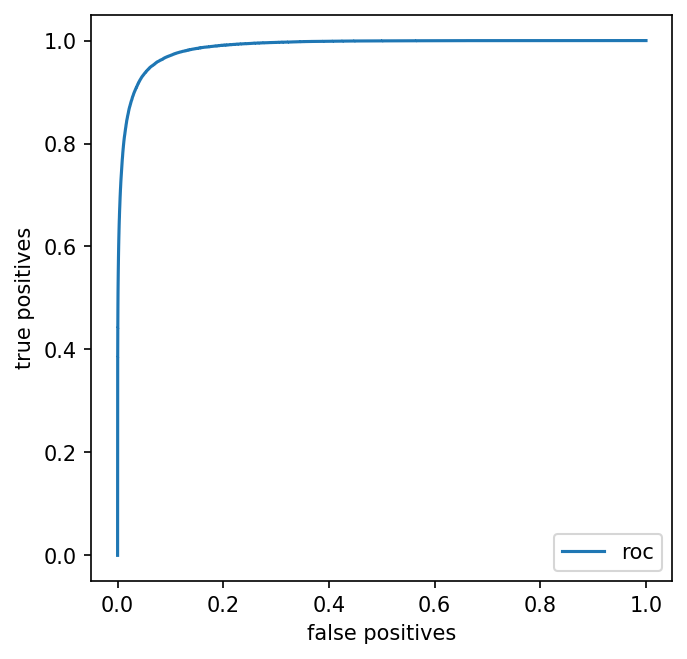

In [12]:
# Evalutation
print(">>> Computing AUC...")

from sklearn.metrics import roc_auc_score, roc_curve

pred = model.predict(X_val,batch_size=2048)
auc = roc_auc_score(y_val, pred, sample_weight=w_val)
print("AUC score: " + str(auc))

print(">>> Saving ROC curve...")
fp , tp, th = roc_curve(y_val, pred, sample_weight=w_val,drop_intermediate=True)
plt.plot(fp, tp, label="roc")
#plt.plot(fp, th, label="threshold")
plt.xlabel("false positives")
plt.ylabel("true positives")
plt.ylim(-0.05,1.05)

plt.legend()

# AUC by eta and Et bin

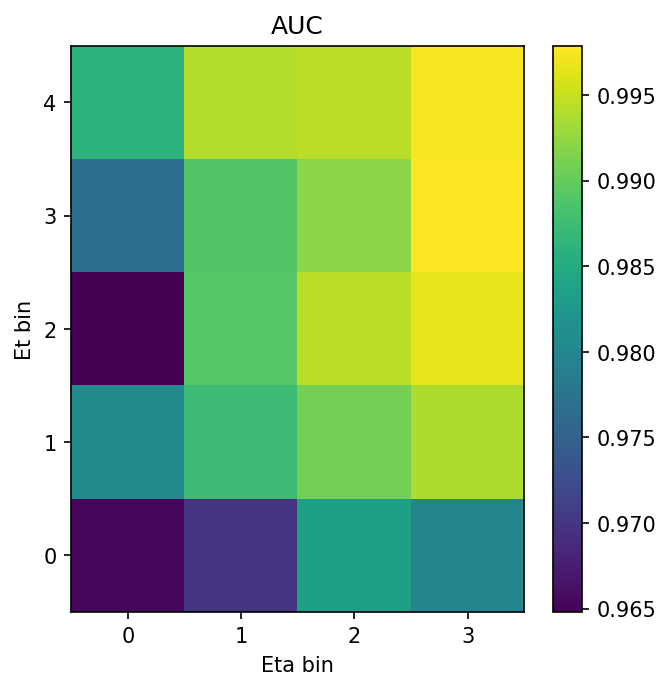

In [13]:
data["y"] =  model.predict(scaler.transform(data[cols].values), batch_size=4096)

ets = [0,20,40,60,80,100]
if det=="EB":
    etas = [0, 0.4,0.8, 1.2,1.479]
if det=="EE":
    etas = [1.479,1.75,2.,2.25,3]

data["eta_bin"] = pd.cut(abs(data.seed_eta), etas, labels=list(range(len(etas)-1)))
data["et_bin"] = pd.cut(data.et_seed, ets, labels=list(range(len(ets)-1)))

result =  data.groupby(["eta_bin", "et_bin"]).apply(
        lambda gr:  roc_auc_score(gr.in_scluster, gr.y, sample_weight=gr.w)
)

a = result.values.reshape((len(etas)-1,len(ets)-1))
plt.imshow(a.T)
plt.xlabel("Eta bin")
plt.ylabel("Et bin")
plt.title("AUC")
plt.colorbar()

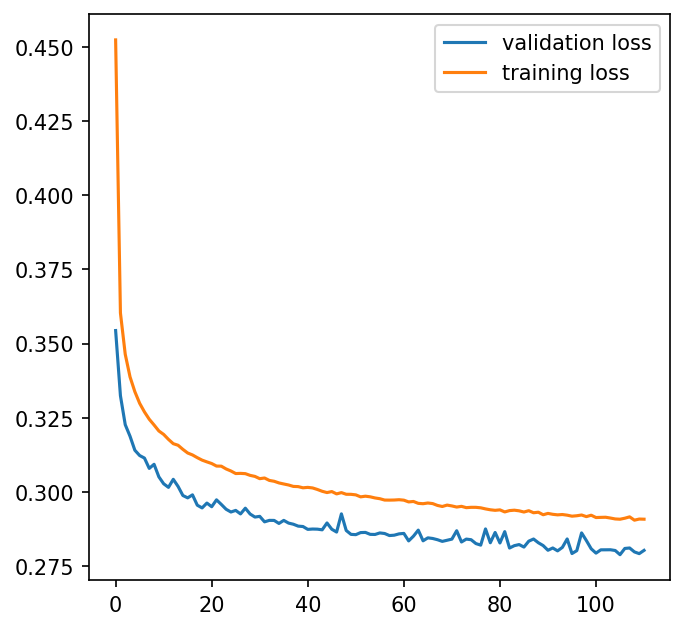

In [14]:
plt.plot(history.epoch, history.history["val_loss"], label="validation loss")
plt.plot(history.epoch, history.history["loss"], label="training loss")
plt.legend()

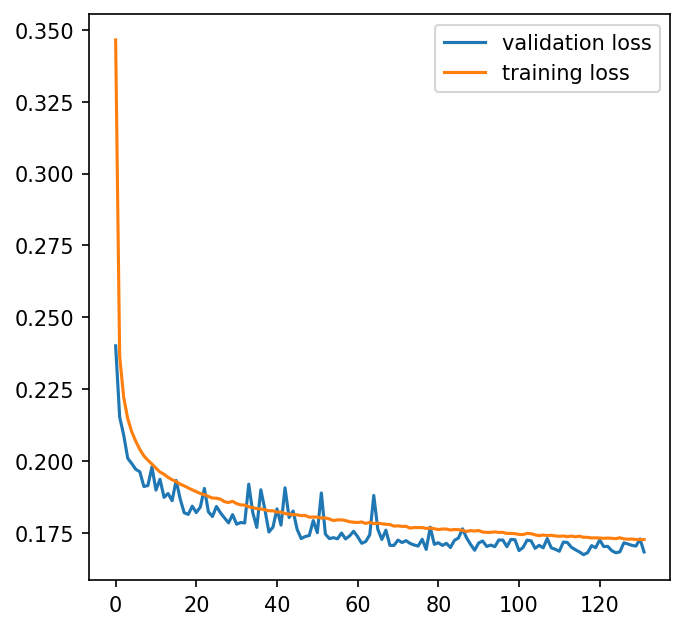

In [26]:
plt.plot(history.epoch, history.history["val_loss"], label="validation loss")
plt.plot(history.epoch, history.history["loss"], label="training loss")
plt.legend()

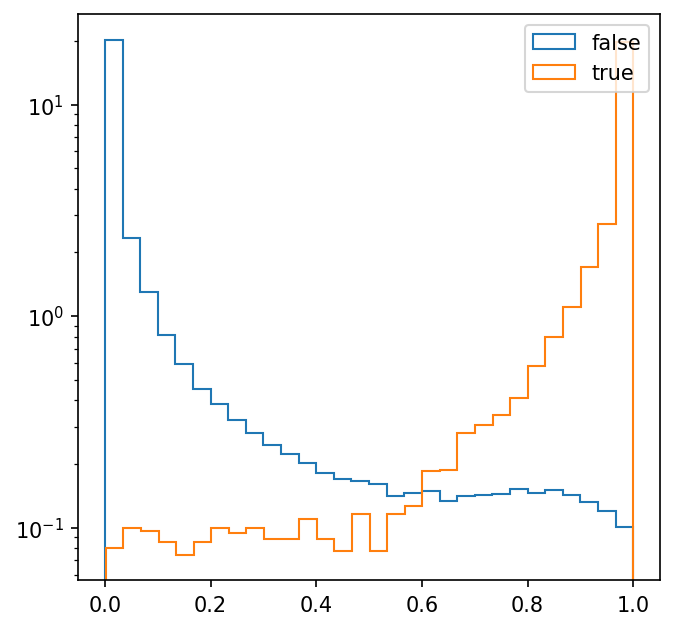

In [15]:
results = model.predict(X_val[:200000])
plt.hist(results[y_val[:200000]==0], bins=30,density=True, label="false", histtype="step")
plt.hist(results[y_val[:200000]==1], bins=30, density=True, label="true", histtype="step")
plt.yscale("log")
plt.legend()

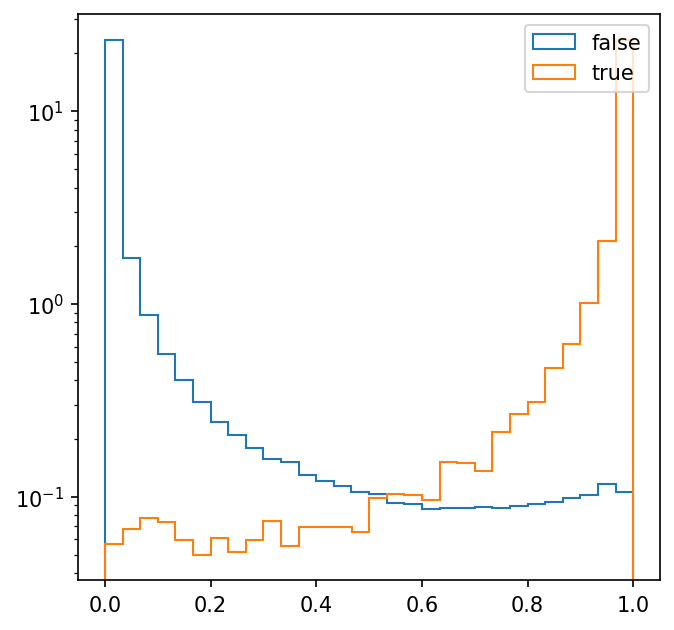

In [15]:
results = model.predict(X_val[:500000])
plt.hist(results[y_val[:500000]==0], bins=30,density=True, label="false", histtype="step")
plt.hist(results[y_val[:500000]==1], bins=30, density=True, label="true", histtype="step")
plt.yscale("log")
plt.legend()

In [25]:
plt.savefig(model_dir +"/output_model_v2_EE.png")

<Figure size 750x750 with 0 Axes>

# Some plots

In [1]:
from keras.models import load_model
model = load_model("models/model11_balanced_100_80_50.hd5")
scaler = pickle.load(open("models/scaler_gamma_electrons.pkl", "rb"))

Using TensorFlow backend.


OSError: Unable to open file (unable to open file: name = 'models/model11_balanced_100_80_50.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
fp , tp, th = roc_curve(y_test, pred)
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
ax1.plot(fp, tp, label="roc", color="blue")

ax1.set_xlabel("Bkg contamination", fontsize=18)
ax1.set_ylabel("Signal efficiency", fontsize=18, color="blue")
ax1.set_ylim(0.850, 1.01)
ax1.set_xlim(0, 0.06)
#ax1.plot([0,1],[1,1],"b--")
ax1.tick_params("y",labelsize="large", labelcolor="blue")

ax2 = ax1.twinx()
ax2.plot(fp, th, label="threshold", color="red")
ax2.tick_params(axis='y', labelcolor="red", labelsize="large")
ax2.set_ylabel("Threshold", fontsize=18, color="red")
ax2.set_ylim(0, 1)
ax1.grid()
#ax2.grid(linestyle="dashed", color="red")

ax2.plot([0.01, 0.01], [0, 2], "g--")
ax2.set_yticks(np.arange(0, 1.1, 0.1))
#ax2.minorticks_on()

ax1.set_title("ROC curve", fontsize=20)
ax2.text(x = 0.048, y = 1.01, s="AUC=0.997", fontsize="large")

fig.tight_layout()

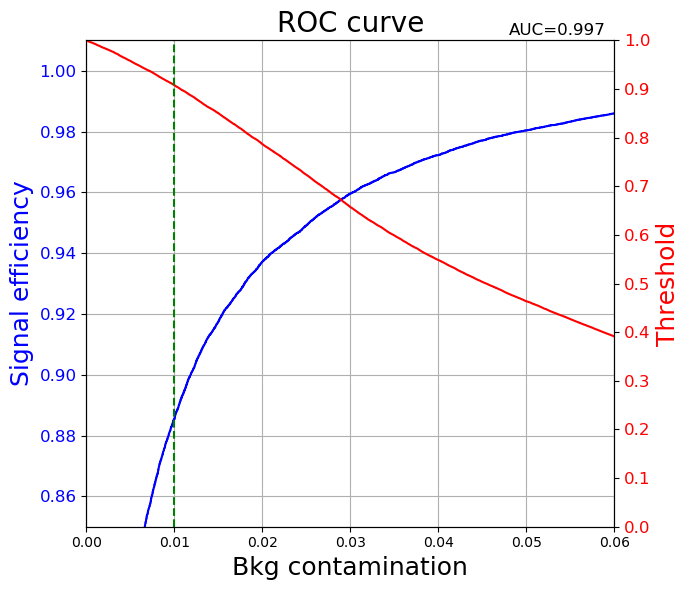

In [36]:
fp , tp, th = roc_curve(y_test, pred)
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
ax1.plot(fp, tp, label="roc", color="blue")

ax1.set_xlabel("Bkg contamination", fontsize=18)
ax1.set_ylabel("Signal efficiency", fontsize=18, color="blue")
ax1.set_ylim(0.850, 1.01)
ax1.set_xlim(0, 0.06)
#ax1.plot([0,1],[1,1],"b--")
ax1.tick_params("y",labelsize="large", labelcolor="blue")

ax2 = ax1.twinx()
ax2.plot(fp, th, label="threshold", color="red")
ax2.tick_params(axis='y', labelcolor="red", labelsize="large")
ax2.set_ylabel("Threshold", fontsize=18, color="red")
ax2.set_ylim(0, 1)
ax1.grid()
#ax2.grid(linestyle="dashed", color="red")

ax2.plot([0.01, 0.01], [0, 2], "g--")
ax2.set_yticks(np.arange(0, 1.1, 0.1))
#ax2.minorticks_on()

ax1.set_title("ROC curve", fontsize=20)
ax2.text(x = 0.048, y = 1.01, s="AUC=0.997", fontsize="large")

fig.tight_layout()